 ## TP 5 : Markov chains & multithreading + _seaborn_

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

### A. Useful tool for visualization: _seaborn_
_seaborn_ is a package designed for nice data and data analysis visualization.
See <http://seaborn.pydata.org/examples/> for examples of nice predefined graphics. Here is a way to represent the empirical distributions of 9 realizations of a bivariate random variable with normal distribution: 

<IPython.core.display.Javascript object>


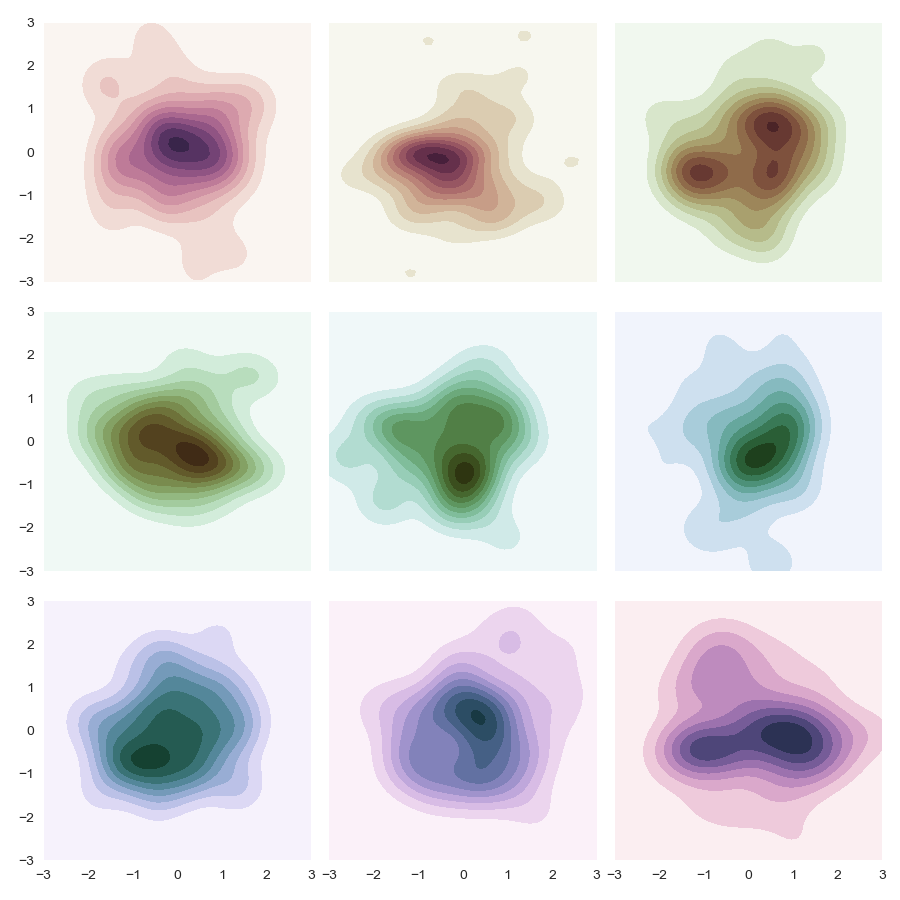

In [10]:
import seaborn as sns

sns.set(style="dark")
rs = np.random.RandomState(50)

# Set up the matplotlib figure
# créé la figure et les axes (au nombre de 9 correspondant aux 9 figures)
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)


# Rotate the starting point around the cubehelix hue circle
# parcours des axes
# à chaque axes est associé un chiffre permettant ultérieurement de changer la couleur du graphe 
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    # créé la pallette de couleur pour un graphe (en fonction de s)
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    # génération de x et y suivant une loi normale 
    x, y = rs.randn(2, 50)
    
    # génération d'une estimation bivariante
    # prenant en compte la palette de couleur définie précédemment 
    # ainsi que les deux tableau de données (x et y)
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
    
    #mise en forme des axes
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

#fonction de mise en forme
f.tight_layout()


### TO DO : 
**What is this example illustrating ?** (try to make each line of the code explicit, including the KDE method...)

## B. Simulation of Markov chains
Let ${(X_n)}_{n\geq 0}$ a Markov chain with values in a finite ensemble 
$E=\{x_1,\dots,x_N\}$ identified to $E=\{1,\dots,N\}$. The initial state is distributed according to:
$$
P(X_0 = k) = \rho_k,\qquad k=1\dots N.
$$
Let $A$ the transition matrix of this chain. We know that if $X_n = k$, the life time of the chain in this state obeys a geometrical law  with parameter $a_{kk}$. We also know that the probability of transition from  k to $\ell\neq k$
is given by:
$$
P(X_{n+1}=\ell | X_n=k, X_{n+1}\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

### One possible algorithm to simulate a Markov chain is therefore:

   a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.
   
   b. at instant $n$, knowing that $X_n=k$,
   
   i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.
   
   ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition.

1. Implement this algorithm in a function yielding `X = Markov(N,rho,A,nmax)` where:
    - N: number of states,
    - rho: law of the initial state (vector of size $N$ summing to 1),
    - A: transition matrix (of size $N\times N$),
    - nmax: number of time steps.

2. Make some simulations using simple Markov matrices (any positive matrix $A=(a_{k\ell})$ such that lines sum to 1) and represent their evolution.

3. Explore the potential of the `multiprocessing` package to implement a multithreaded version so that several Markov chains can be simulated in parallel.

See <https://docs.python.org/2/library/multiprocessing.html>

In [2]:
# a) 
def choose_state(prob):
    i=0
    # génération d'un chiffre entre 0 et 1 suivant une loi uniforme
    choice = np.random.uniform(0,1)
    diff = prob[0]
    # si la valeur générée est inférieur à la variable diff on retourne le i actuel
    # qui correspond à X0-1 (états compris entre 1 et N)
    while (choice>diff) : 
        i += 1
        diff += prob[i]
    return i+1

x0_state=choose_state([0.2,0.3,0.5])
print(x0_state)

3


In [3]:
# b) i.
def life_time(akk) :
    T=0 
    #simulation de la loi géométrique grâce à la fonction précédente
    while (choose_state([akk,1-akk])==1) : 
        T += 1
    return T 


In [4]:
for i in range(10): 
    print(life_time(0.9))

6
9
15
14
1
19
28
2
11
6


In [5]:
#b) ii.
def next_transition(k,A) :
    #array_ak correspond à la kième ligne de la matrice de transition
    array_k = A[k-1]
    #détermine le temps passé dans l'état k (suivant la fonction précédente)
    T = life_time(array_k[k-1])
    prob_array = array_k/(1-array_k[k-1])
    prob_array[k-1] = 0
    nextState = choose_state(prob_array)
    return T,nextState
A=np.array([[0.3,0.4,0.3],
  [0.1,0.7,0.2],
  [0.4,0.2,0.4]])
T, nextState = next_transition(2,A)

print(T)
print(nextState)
    


3
1


In [6]:
def Markov(rho,A,nmax): 
    state = [0 for i in range(nmax)]
    state[0] = choose_state(rho)
    i = 1
    while (i<nmax):  
        T,nextState = next_transition(state[i-1],A)
        for j in range (T+1) :
            state[min(i,nmax-1)] = nextState
            i += 1
    return state

A=np.array([[0.3,0.4,0.3],
  [0.1,0.7,0.2],
  [0.4,0.2,0.4]])
rho=np.array([0.2,0.5,0.3])
print(Markov(rho,A,100))

[2, 3, 3, 1, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 2, 3, 2, 2, 1, 2, 2, 3, 3, 3, 3, 3, 1, 1]


In [23]:
def generate_prob_array(n, threshold,col): 
    array=np.random.uniform(0,1,size=n)
    for i in range(n): 
        if (array[i]<threshold and i!=col):
            array[i]=0
    res=np.sum(array)
    array=array/res
    return array

def generate_a(n):
    threshold=np.random.uniform(0.3,0.6,size=n)
    a=np.zeros((n,n))
    for i in range(n):
        a[i]=generate_prob_array(n,threshold[i],i)
    return a


In [28]:
from graphviz import Digraph
from IPython.display import Image
def create_graph_node(A,pos):
    graph=Digraph(format='png')
    for i in range(len(A)): 
        if (i==pos-1): 
            graph.node(str(i+1),str(i+1),color='red')
        else : 
            graph.node(str(i+1),str(i+1))
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                graph.edge(str(i+1),str(j+1))
    return graph 
def create_graph_edge(A,pos1,pos2):
    graph=Digraph(format='png')
    for i in range(len(A)): 
        graph.node(str(i+1),str(i+1))
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                if (i==pos1-1 and j==pos2-1):
                    graph.edge(str(i+1),str(j+1),color='green')
                else : 
                    graph.edge(str(i+1),str(j+1))
    return graph

def display_graph(graph): 
    file=graph.render()
    display(Image(filename=file))

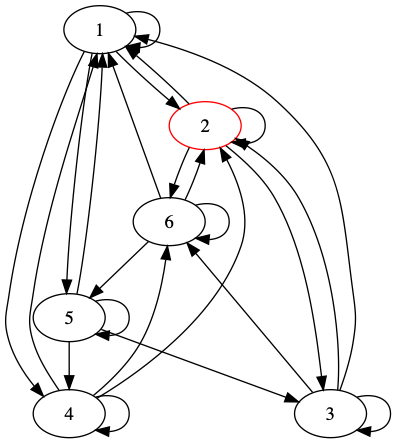

In [32]:
from IPython.display import clear_output
import time

def show_markov(rho,A,nmax):
    path = Markov(rho,A,nmax)
    for i in range(len(path)-1): 
        print("node")
        print(i)
        print(path)
        display_graph(create_graph_node(A,path[i]))
        time.sleep(0.8)
        clear_output()
        print("edge")
        print(i)
        print(path)
        display_graph(create_graph_edge(A,path[i],path[i+1]))
        time.sleep(0.8)
        clear_output()
    display_graph(create_graph_node(A,path[-1]))

rho=generate_prob_array(6,0,0)
A=generate_a(6)

show_markov(rho,A,20)
    

In [ ]:
from graphviz import Digraph
from IPython.display import Image
def create_graph_node(A,pos):
    graph=Digraph(format='png')
    for i in range(len(A)): 
        if (i==pos): 
            graph.node(str(i+1),str(i+1),color='red')
        else : 
            graph.node(str(i+1),str(i+1))
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                graph.edge(str(i+1),str(j+1))
    return graph 
def create_graph_edge(A,pos1,pos2):
    graph=Digraph(format='png')
    for i in range(len(A)): 
        graph.node(str(i+1),str(i+1))
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                if (i==pos1 and j==pos2):
                    graph.edge(str(i+1),str(j+1),color='green')
                else : 
                    graph.edge(str(i+1),str(j+1))
    return graph

def display_graph(graph): 
    file=graph.render()
    display(Image(filename=file))
    from graphviz import Digraph
from IPython.display import Image
def create_graph_node(A,pos):
    graph=Digraph(format='png')
    for i in range(len(A)): 
        if (i==pos): 
            graph.node(str(i+1),str(i+1),color='red')
        else : 
            graph.node(str(i+1),str(i+1))
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                graph.edge(str(i+1),str(j+1))
    return graph 
def create_graph_edge(A,pos1,pos2):
    graph=Digraph(format='png')
    for i in range(len(A)): 
        graph.node(str(i+1),str(i+1))
    for i in range(len(A)):
        for j in range(len(A)): 
            if (A[i,j]!=0):
                if (i==pos1 and j==pos2):
                    graph.edge(str(i+1),str(j+1),color='green')
                else : 
                    graph.edge(str(i+1),str(j+1))
    return graph

def display_graph(graph): 
    file=graph.render()
    display(Image(filename=file))